In [20]:
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In this code I will explore how a basic momentum based trading strategy based on the support and resistance level, to make the strategy more practical I will will use tolerance levels insted of limits so that if a price falls into the tollerance level there is a hit and after two consecutive hits we wil take a short or long position

In [21]:
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME='goog_data.pkl'
try:
    goog_data = pd.read_pickle(SRC_DATA_FILENAME)
    print('File data found...reading GOOG data')
except FileNotFoundError:
    print('File not found...downloading the GOOG data')
    goog_data = data.DataReader('GOOG', 'yahoo', start_date, end_date)
    goog_data.to_pickle(SRC_DATA_FILENAME)
    goog_data_signal = pd.DataFrame(index=goog_data.index)
    goog_data_signal['price'] = goog_data['Adj Close']
    
# in this i am saving the data for google stock in a csv file becuase I will have to use the raw data
# for every day calculations so its better to save it on the pc

File data found...reading GOOG data


In [41]:
def trading_support_resistance(data, bin_width=20):
    data['sup_tolerance'] = pd.Series(np.zeros(len(data)))
    data['res_tolerance'] = pd.Series(np.zeros(len(data)))
    data['sup_count'] = pd.Series(np.zeros(len(data)))
    data['res_count'] = pd.Series(np.zeros(len(data)))
    data['sup'] = pd.Series(np.zeros(len(data)))
    data['res'] = pd.Series(np.zeros(len(data)))
    data['positions'] = pd.Series(np.zeros(len(data)))
    data['signal'] = pd.Series(np.zeros(len(data)))
    in_support=0
    in_resistance=0

# this sets a time frame for the data so that we can calculate the support and resistance levels for the period 
# and the set day frame is 20 days in this 


    for x in range((bin_width - 1) + bin_width, len(data)):
        data_section = data[x - bin_width:x + 1]
        support_level=min(data_section['price'])
        resistance_level=max(data_section['price'])
        range_level=resistance_level-support_level
        data['res'][x]=resistance_level
        data['sup'][x]=support_level
        data['sup_tolerance'][x]=support_level + 0.2 * range_level
        data['res_tolerance'][x]=resistance_level - 0.2 * range_level
#         here you can see that we haev chosen the tolerance level to be of 20 percent of the range so if
# the price prevails in this region fo sup/res we will take our short and long position respectivley 
        if data['price'][x]>=data['res_tolerance'][x] and data['price'][x] <= data['res'][x]:
            in_resistance+=1
            data['res_count'][x]=in_resistance
        elif data['price'][x] <= data['sup_tolerance'][x] and  data['price'][x] >= data['sup'][x]:
                in_support += 1
                data['sup_count'][x] = in_support
        else:
            in_support=0
            in_resistance=0


        if in_resistance>2:
            data['signal'][x]=1
        elif in_support>2:
            data['signal'][x]=0
        else:
            data['signal'][x] = data['signal'][x-1]
    
            
    data['positions']=data['signal'].diff()
    print(data.tail(150))

In [42]:
trading_support_resistance(goog_data_signal)

                  price  sup_tolerance  res_tolerance  sup_count  res_count  \
Date                                                                          
2017-05-30   975.880005     925.232007     963.218005        NaN        8.0   
2017-05-31   964.859985     928.328003     963.992004        NaN        9.0   
2017-06-01   966.950012     930.871997     964.628003        NaN       10.0   
2017-06-02   975.599976     930.871997     964.628003        NaN       11.0   
2017-06-05   983.679993     932.431995     970.867993        NaN       12.0   
...                 ...            ...            ...        ...        ...   
2017-12-22  1060.119995    1014.371997    1061.448010        NaN        NaN   
2017-12-26  1056.739990    1014.371997    1061.448010        NaN        NaN   
2017-12-27  1049.369995    1014.371997    1061.448010        NaN        NaN   
2017-12-28  1048.140015    1014.371997    1061.448010        NaN        NaN   
2017-12-29  1046.400024    1014.371997    1061.44801

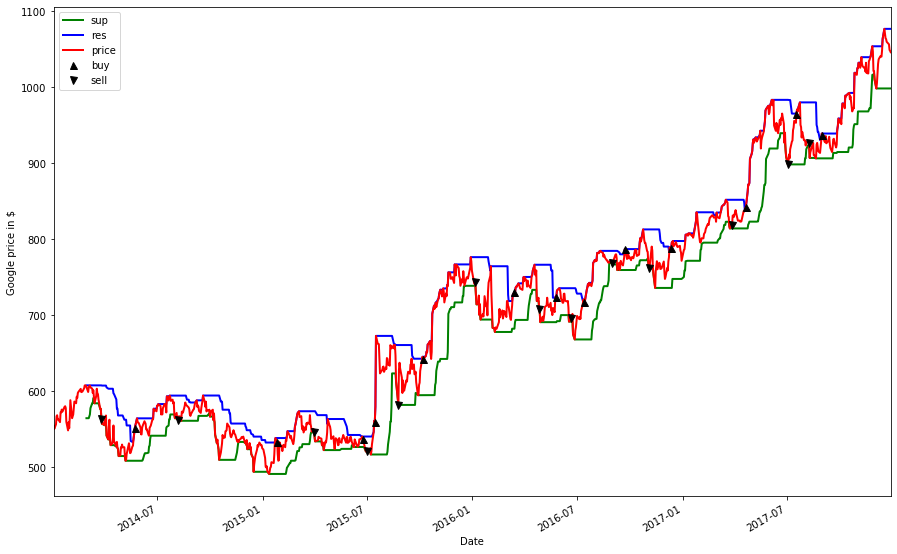

In [36]:
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(111, ylabel='Google price in $')
goog_data_signal['sup'].plot(ax=ax1, color='g', lw=2.)
goog_data_signal['res'].plot(ax=ax1, color='b', lw=2.)
goog_data_signal['price'].plot(ax=ax1, color='r', lw=2.)
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
goog_data_signal.price[goog_data_signal.positions == 1.0],
'^', markersize=7, color='k',label='buy')
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
goog_data_signal.price[goog_data_signal.positions == -1.0],
'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

In the Diagram above we can see that we we plot a down facing arrow we are in a short position as the prices has touched the resistance tolerance twice and when we plot upward facing arrow we are in a short position as the stock has prevailed in the resistance tolearnce level twice.